In [ ]:
import tensorflow as tf
try: [tf.config.experimental.set_memory_growth(gpu, True) for gpu in tf.config.experimental.list_physical_devices("GPU")]
except: pass

In [ ]:
!pip install mltu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.7 MB/s eta 0:00:00
  Created wheel for qqdm: filename=qqdm-0.0.7-py3-none-any.whl size=6466 sha256=830fe9ed215c813d9d7f7849f0945c83e5d0eb363025a2757a2b663dbef56b3d
  Stored in directory: /root/.cache/pip/wheels/40/1a/56/5dccdea123a172661eb65c8c29fde4567dbda2b72b5fc5893a
Successfully built qqdm


In [ ]:
import mltu

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage

from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CWERMetric

In [ ]:
import os
import tarfile
from tqdm import tqdm
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

In [ ]:
def download_and_unzip(url, extract_to="Datasets", chunk_size=1024*1024):
    http_response = urlopen(url)

    data = b""
    iterations = http_response.length // chunk_size + 1
    for _ in tqdm(range(iterations)):
        data += http_response.read(chunk_size)

    zipfile = ZipFile(BytesIO(data))
    zipfile.extractall(path=extract_to)

dataset_path = os.path.join("Datasets", "IAM_Words")
if not os.path.exists(dataset_path):
    download_and_unzip("https://git.io/J0fjL", extract_to="Datasets")

    file = tarfile.open(os.path.join(dataset_path, "words.tgz"))
    file.extractall(os.path.join(dataset_path, "words"))

dataset, vocab, max_len = [], set(), 0

# Preprocess the dataset by the specific IAM_Words dataset file structure
words = open(os.path.join(dataset_path, "words.txt"), "r").readlines()
for line in tqdm(words):
    if line.startswith("#"):
        continue

    line_split = line.split(" ")
    if line_split[1] == "err":
        continue

    folder1 = line_split[0][:3]
    folder2 = "-".join(line_split[0].split("-")[:2])
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip("\n")

    rel_path = os.path.join(dataset_path, "words", folder1, folder2, file_name)
    if not os.path.exists(rel_path):
        print(f"File not found: {rel_path}")
        continue

    dataset.append([rel_path, label])
    vocab.update(list(label))
    max_len = max(max_len, len(label))

100%|██████████| 115338/115338 [00:01<00:00, 85844.75it/s]


# configs.py

In [ ]:
import os
from datetime import datetime

from mltu.configs import BaseModelConfigs

class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = os.path.join("Models/03_handwriting_recognition", datetime.strftime(datetime.now(), "%Y%m%d%H%M"))
        self.vocab = ""
        self.height = 32
        self.width = 128
        self.max_text_length = 0
        self.batch_size = 16
        self.learning_rate = 0.0005
        self.train_epochs = 10
        self.train_workers = 20

# model.py

In [ ]:
from keras import layers
from keras.models import Model

from mltu.tensorflow.model_utils import residual_block


def train_model(input_dim, output_dim, activation="leaky_relu", dropout=0.2):

    inputs = layers.Input(shape=input_dim, name="input")

    # normalize images here instead in preprocessing step
    input = layers.Lambda(lambda x: x / 255)(inputs)

    x1 = residual_block(input, 16, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x2 = residual_block(x1, 16, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x3 = residual_block(x2, 16, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x4 = residual_block(x3, 32, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x5 = residual_block(x4, 32, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    x6 = residual_block(x5, 64, activation=activation, skip_conv=True, strides=2, dropout=dropout)
    x7 = residual_block(x6, 64, activation=activation, skip_conv=True, strides=1, dropout=dropout)

    x8 = residual_block(x7, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)
    x9 = residual_block(x8, 64, activation=activation, skip_conv=False, strides=1, dropout=dropout)

    squeezed = layers.Reshape((x9.shape[-3] * x9.shape[-2], x9.shape[-1]))(x9)

    blstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(squeezed)
    blstm = layers.Dropout(dropout)(blstm)

    output = layers.Dense(output_dim + 1, activation="softmax", name="output")(blstm)

    model = Model(inputs=inputs, outputs=output)
    return model

# train.py

In [ ]:
!pip install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 28.2 MB/s eta 0:00:00


# inference

In [ ]:
import cv2
import typing
import numpy as np
import matplotlib.pyplot as plt

from mltu.inferenceModel import OnnxInferenceModel
from mltu.utils.text_utils import ctc_decoder, get_cer

  0%|          | 10/2171 [00:00<00:22, 97.17it/s]

Image: Datasets/IAM_Words/words/g06/g06-031o/g06-031o-07-04.png, Label: upon, Prediction: upon, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026e/g06-026e-02-03.png, Label: not, Prediction: not, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050g/g06-050g-06-00.png, Label: appears, Prediction: appears, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-058u/a01-058u-01-01.png, Label: West, Prediction: West, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-046b/f07-046b-08-04.png, Label: shop, Prediction: shop, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050i/g06-050i-04-08.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096c/c03-096c-05-06.png, Label: because, Prediction: because, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003c/c03-003c-06-02.png, Label: premiere, Prediction: premiere, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-076a/f07-076a-02-04.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018a/g06-

  2%|▏         | 47/2171 [00:00<00:18, 116.20it/s]

Image: Datasets/IAM_Words/words/g06/g06-050g/g06-050g-02-01.png, Label: his, Prediction: his, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-026a/g07-026a-09-00.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-000a/c03-000a-04-01.png, Label: with, Prediction: with, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087c/c03-087c-04-09.png, Label: whether, Prediction: whether, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-063a/h07-063a-05-09.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011l/g06-011l-05-07.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018e/g06-018e-04-05.png, Label: been, Prediction: been, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045n/g06-045n-00-07.png, Label: wife's, Prediction: wifes, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/g06/g06-011n/g06-011n-08-02.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018m/g06-018

  3%|▎         | 59/2171 [00:00<00:19, 109.81it/s]

Image: Datasets/IAM_Words/words/c03/c03-000d/c03-000d-06-06.png, Label: conception, Prediction: conception, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047k/g06-047k-00-04.png, Label: medicine, Prediction: medicine, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-028b/g07-028b-04-02.png, Label: ever, Prediction: ever, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-096u/a01-096u-04-00.png, Label: has, Prediction: was, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/a01/a01-091u/a01-091u-03-02.png, Label: Government, Prediction: Government, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-024a/f07-024a-07-07.png, Label: from, Prediction: from, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-026b/g07-026b-03-08.png, Label: her, Prediction: her, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031l/g06-031l-03-05.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084f/c03-084f-04-08.png, Label: series, Prediction: series, CER: 0.0
Image: Dat

  4%|▍         | 82/2171 [00:00<00:22, 92.66it/s] 

Image: Datasets/IAM_Words/words/g06/g06-018l/g06-018l-06-05.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-066b/h07-066b-03-02.png, Label: abnormal, Prediction: ahommal, CER: 0.375
Image: Datasets/IAM_Words/words/g06/g06-026e/g06-026e-00-06.png, Label: It, Prediction: I, CER: 0.5
Image: Datasets/IAM_Words/words/g06/g06-037l/g06-037l-03-05.png, Label: there, Prediction: there, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-113u/a01-113u-01-05.png, Label: fundamentally, Prediction: frotonsentaly, CER: 0.5384615384615384
Image: Datasets/IAM_Words/words/g06/g06-045r/g06-045r-02-05.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-011u/a01-011u-05-01.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-000f/c03-000f-07-01.png, Label: conception, Prediction: conception, CER: 0.0
Image: Datasets/IAM_Words/words/k07/k07-059a/k07-059a-04-08.png, Label: well, Prediction: well, CER: 0.0
Image: Datasets/IAM_

  5%|▍         | 102/2171 [00:01<00:22, 92.62it/s]

Image: Datasets/IAM_Words/words/g06/g06-045p/g06-045p-03-06.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018k/g06-018k-01-08.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-084b/f07-084b-05-08.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047l/g06-047l-05-02.png, Label: these, Prediction: these, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018f/g06-018f-01-00.png, Label: England, Prediction: England, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-032b/f07-032b-11-00.png, Label: far, Prediction: far, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018l/g06-018l-04-00.png, Label: The, Prediction: The, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011i/g06-011i-05-11.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011i/g06-011i-05-08.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037o/g06-037o-02-08.png, Label: ,, Pr

  5%|▌         | 112/2171 [00:01<00:22, 91.71it/s]

Image: Datasets/IAM_Words/words/g06/g06-050e/g06-050e-02-07.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-096u/a01-096u-05-01.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018f/g06-018f-05-01.png, Label: high, Prediction: high, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-054a/h07-054a-02-07.png, Label: probably, Prediction: probably, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003b/c03-003b-03-00.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045m/g06-045m-05-02.png, Label: Italy, Prediction: Italy, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-046b/f07-046b-05-03.png, Label: from, Prediction: froe, CER: 0.25
Image: Datasets/IAM_Words/words/g06/g06-018c/g06-018c-05-11.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-102u/a01-102u-07-03.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042b/g06-042b-04-09.png, L

  6%|▌         | 131/2171 [00:01<00:23, 85.87it/s]

Image: Datasets/IAM_Words/words/c03/c03-094f/c03-094f-00-01.png, Label: William, Prediction: Volim, CER: 0.5714285714285714
Image: Datasets/IAM_Words/words/g06/g06-031f/g06-031f-01-01.png, Label: I, Prediction: I, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007d/c03-007d-03-01.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011a/g06-011a-01-01.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003b/c03-003b-05-01.png, Label: Fanny, Prediction: Fonny, CER: 0.2
Image: Datasets/IAM_Words/words/c03/c03-096f/c03-096f-00-05.png, Label: therefore, Prediction: themefore, CER: 0.1111111111111111
Image: Datasets/IAM_Words/words/g06/g06-050g/g06-050g-01-08.png, Label: advice, Prediction: advice, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026g/g06-026g-00-02.png, Label: life, Prediction: life, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018p/g06-018p-06-10.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words

  7%|▋         | 149/2171 [00:01<00:26, 76.11it/s]

Image: Datasets/IAM_Words/words/c03/c03-096a/c03-096a-00-07.png, Label: arose, Prediction: arrose, CER: 0.2
Image: Datasets/IAM_Words/words/g06/g06-026o/g06-026o-07-02.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-057a/h07-057a-01-07.png, Label: offices, Prediction: offices, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087e/c03-087e-04-05.png, Label: unredeemable, Prediction: unedemable, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/a01/a01-043x/a01-043x-06-08.png, Label: discrimination, Prediction: dismilation, CER: 0.2857142857142857
Image: Datasets/IAM_Words/words/c03/c03-087b/c03-087b-04-05.png, Label: unredeemable, Prediction: unredemable, CER: 0.08333333333333333
Image: Datasets/IAM_Words/words/c03/c03-081b/c03-081b-02-00.png, Label: herself, Prediction: herself, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-022b/g07-022b-01-04.png, Label: she, Prediction: she, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047o/g06-047o-08

  8%|▊         | 166/2171 [00:01<00:25, 77.90it/s]

Image: Datasets/IAM_Words/words/h07/h07-071a/h07-071a-07-06.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011o/g06-011o-08-03.png, Label: -, Prediction: -, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-026x/a01-026x-07-01.png, Label: Sir, Prediction: Sir, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011b/g06-011b-03-01.png, Label: him, Prediction: him, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011h/g06-011h-04-02.png, Label: Vesuvius, Prediction: Vesuvius, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031m/g06-031m-04-00.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-007a/g07-007a-03-04.png, Label: STEWARD, Prediction: STENAED, CER: 0.2857142857142857
Image: Datasets/IAM_Words/words/n02/n02-082a/n02-082a-02-05.png, Label: With, Prediction: wile, CER: 0.75
Image: Datasets/IAM_Words/words/g06/g06-042j/g06-042j-00-03.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-028

  8%|▊         | 182/2171 [00:02<00:26, 74.59it/s]

Image: Datasets/IAM_Words/words/a01/a01-107u/a01-107u-07-06.png, Label: can, Prediction: can, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081c/c03-081c-01-04.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021d/c03-021d-07-02.png, Label: forlorn, Prediction: forlorn, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007e/c03-007e-00-06.png, Label: Richardson, Prediction: Richardson, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096d/c03-096d-03-03.png, Label: author, Prediction: author, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-000f/c03-000f-06-00.png, Label: advantages, Prediction: advantages, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-016b/c03-016b-07-03.png, Label: As, Prediction: As, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003e/c03-003e-07-00.png, Label: Mr., Prediction: Mr., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045l/g06-045l-02-05.png, Label: trial, Prediction: trial, CER: 0.0
Image: Datasets/IAM_Words/words

  9%|▉         | 199/2171 [00:02<00:25, 78.66it/s]

Image: Datasets/IAM_Words/words/c03/c03-000f/c03-000f-00-03.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050h/g06-050h-02-02.png, Label: described, Prediction: described, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011r/g06-011r-03-06.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-028b/f07-028b-10-00.png, Label: palate, Prediction: palate, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037p/g06-037p-07-03.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011g/g06-011g-02-06.png, Label: ', Prediction: ., CER: 1.0
Image: Datasets/IAM_Words/words/g07/g07-003b/g07-003b-04-06.png, Label: deceased, Prediction: decaned, CER: 0.25
Image: Datasets/IAM_Words/words/a01/a01-043u/a01-043u-05-00.png, Label: Deep, Prediction: Dees, CER: 0.25
Image: Datasets/IAM_Words/words/g07/g07-077a/g07-077a-00-01.png, Label: Anson, Prediction: Anson, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-081b/f07

 10%|▉         | 217/2171 [00:02<00:24, 78.70it/s]

Image: Datasets/IAM_Words/words/c03/c03-021d/c03-021d-06-10.png, Label: gives, Prediction: gives, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031a/g06-031a-00-09.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021f/c03-021f-07-00.png, Label: He, Prediction: He, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037f/g06-037f-03-03.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-032b/f07-032b-00-03.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031c/g06-031c-06-09.png, Label: Radicalism, Prediction: Radicalish, CER: 0.1
Image: Datasets/IAM_Words/words/a01/a01-014x/a01-014x-09-00.png, Label: Macmillan, Prediction: Macmilan, CER: 0.1111111111111111
Image: Datasets/IAM_Words/words/g06/g06-037i/g06-037i-06-06.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047k/g06-047k-02-02.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/f07/f07-024

 11%|█         | 234/2171 [00:02<00:24, 79.14it/s]

Image: Datasets/IAM_Words/words/g06/g06-011o/g06-011o-03-01.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050j/g06-050j-05-00.png, Label: man, Prediction: ham, CER: 0.6666666666666666
Image: Datasets/IAM_Words/words/c03/c03-003a/c03-003a-02-08.png, Label: qualities, Prediction: qualities, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045n/g06-045n-01-04.png, Label: Lord, Prediction: Lord, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042j/g06-042j-00-01.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081d/c03-081d-02-01.png, Label: herself, Prediction: herself, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018k/g06-018k-00-03.png, Label: season, Prediction: season, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031g/g06-031g-04-03.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/n02/n02-082a/n02-082a-06-05.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-03

 12%|█▏        | 251/2171 [00:02<00:23, 80.47it/s]


Image: Datasets/IAM_Words/words/c03/c03-021a/c03-021a-02-05.png, Label: moved, Prediction: moved, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026b/g06-026b-03-08.png, Label: word, Prediction: word, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011l/g06-011l-01-02.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-007b/g07-007b-03-06.png, Label: dead, Prediction: clead, CER: 0.5
Image: Datasets/IAM_Words/words/g06/g06-042g/g06-042g-00-09.png, Label: even, Prediction: even, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037i/g06-037i-01-15.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045g/g06-045g-01-06.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-032b/f07-032b-06-08.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-016a/c03-016a-05-04.png, Label: she, Prediction: she, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011l/g06-011l-08-06.png, Labe

 12%|█▏        | 269/2171 [00:03<00:23, 81.87it/s]


Image: Datasets/IAM_Words/words/g06/g06-045g/g06-045g-02-09.png, Label: it, Prediction: it, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-040b/h07-040b-03-02.png, Label: corners, Prediction: Cormes, CER: 0.42857142857142855
Image: Datasets/IAM_Words/words/g06/g06-037i/g06-037i-06-03.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031r/g06-031r-00-04.png, Label: event, Prediction: event, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-021a/f07-021a-06-01.png, Label: we, Prediction: we, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045l/g06-045l-02-07.png, Label: adding, Prediction: adding, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042i/g06-042i-00-13.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031m/g06-031m-04-03.png, Label: be, Prediction: be, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-107u/a01-107u-05-02.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-022b/g07-02

 13%|█▎        | 288/2171 [00:03<00:21, 87.32it/s]

Image: Datasets/IAM_Words/words/f07/f07-042a/f07-042a-03-00.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-094d/c03-094d-02-07.png, Label: Mr., Prediction: Mr., CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-007x/a01-007x-00-01.png, Label: 1958, Prediction: 1835, CER: 0.75
Image: Datasets/IAM_Words/words/g06/g06-026b/g06-026b-00-07.png, Label: so, Prediction: so, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011m/g06-011m-08-04.png, Label: change, Prediction: change, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045f/g06-045f-04-05.png, Label: studied, Prediction: studied, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084c/c03-084c-00-03.png, Label: production, Prediction: production, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050e/g06-050e-05-08.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-026b/g07-026b-02-06.png, Label: long, Prediction: by, CER: 1.0
Image: Datasets/IAM_Words/words/g06/g06-050d/g06

 14%|█▎        | 297/2171 [00:03<00:23, 79.22it/s]

Image: Datasets/IAM_Words/words/a01/a01-020u/a01-020u-06-02.png, Label: African, Prediction: African, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042o/g06-042o-07-00.png, Label: brought, Prediction: brought, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-000a/g07-000a-07-08.png, Label: AND, Prediction: AND, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087a/c03-087a-00-00.png, Label: It, Prediction: It, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018m/g06-018m-01-00.png, Label: back, Prediction: bak, CER: 0.25
Image: Datasets/IAM_Words/words/g07/g07-074a/g07-074a-06-01.png, Label: find, Prediction: find, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050a/g06-050a-02-00.png, Label: In, Prediction: In, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096d/c03-096d-05-04.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/k07/k07-067a/k07-067a-01-05.png, Label: calmly, Prediction: calomly, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/

 15%|█▍        | 315/2171 [00:03<00:22, 81.41it/s]

Image: Datasets/IAM_Words/words/c03/c03-096d/c03-096d-02-07.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-030u/a01-030u-03-07.png, Label: ", Prediction: ", CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-084b/f07-084b-05-02.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037r/g06-037r-00-01.png, Label: grant, Prediction: grant, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037d/g06-037d-03-03.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011r/g06-011r-00-00.png, Label: By, Prediction: By, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-037a/h07-037a-02-05.png, Label: initial, Prediction: initial, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-042a/f07-042a-01-02.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-000f/c03-000f-02-06.png, Label: has, Prediction: has, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050b/g06-050b-06-07.png, Label: ,, Pr

 15%|█▌        | 332/2171 [00:03<00:25, 72.40it/s]

Image: Datasets/IAM_Words/words/g07/g07-069a/g07-069a-02-03.png, Label: effect, Prediction: effect, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-066b/h07-066b-02-07.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045b/g06-045b-03-00.png, Label: give, Prediction: give, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-024b/f07-024b-03-02.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031b/g06-031b-05-05.png, Label: great, Prediction: great, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-071a/g07-071a-02-04.png, Label: this, Prediction: this, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026j/g06-026j-05-07.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031o/g06-031o-05-01.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-068u/a01-068u-08-05.png, Label: keeping, Prediction: teeping, CER: 0.14285714285714285
Image: Datasets/IAM_Words/words/g06/g06-045e/g0

 16%|█▌        | 340/2171 [00:04<00:25, 70.64it/s]

Image: Datasets/IAM_Words/words/g06/g06-050r/g06-050r-01-05.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-000u/a01-000u-00-06.png, Label: from, Prediction: from, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-020u/a01-020u-03-03.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026j/g06-026j-01-06.png, Label: perhaps, Prediction: perhaps, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-082u/a01-082u-05-02.png, Label: development, Prediction: development, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084b/c03-084b-03-03.png, Label: night's, Prediction: nighet's, CER: 0.14285714285714285
Image: Datasets/IAM_Words/words/g06/g06-031m/g06-031m-00-14.png, Label: What, Prediction: What, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-117u/a01-117u-08-00.png, Label: patients, Prediction: patieunts, CER: 0.125
Image: Datasets/IAM_Words/words/g06/g06-037h/g06-037h-04-07.png, Label: opened, Prediction: opened, CER: 0.0
Image: 

 16%|█▋        | 358/2171 [00:04<00:23, 76.02it/s]

Image: Datasets/IAM_Words/words/c03/c03-021d/c03-021d-05-00.png, Label: acts, Prediction: acts, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042f/g06-042f-01-00.png, Label: no, Prediction: no, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037r/g06-037r-01-03.png, Label: may, Prediction: way, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/g07/g07-000b/g07-000b-04-05.png, Label: than, Prediction: than, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031m/g06-031m-00-12.png, Label: tremble, Prediction: tremble, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018h/g06-018h-03-01.png, Label: Arthur, Prediction: Arthur, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018g/g06-018g-05-04.png, Label: but, Prediction: but, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-088a/f07-088a-02-06.png, Label: which, Prediction: which, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-000c/c03-000c-04-01.png, Label: with, Prediction: with, CER: 0.0
Image: Datasets/IAM_Words/words/h07/

 18%|█▊        | 382/2171 [00:04<00:23, 77.06it/s]

Image: Datasets/IAM_Words/words/g06/g06-042e/g06-042e-02-02.png, Label: As, Prediction: As, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-043u/a01-043u-03-00.png, Label: his, Prediction: his, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-003x/a01-003x-05-04.png, Label: forward, Prediction: fasuard, CER: 0.42857142857142855
Image: Datasets/IAM_Words/words/g06/g06-026c/g06-026c-02-03.png, Label: But, Prediction: but, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/g06/g06-011o/g06-011o-10-03.png, Label: fine, Prediction: finie, CER: 0.25
Image: Datasets/IAM_Words/words/g06/g06-026e/g06-026e-00-03.png, Label: truly, Prediction: truly, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-081a/f07-081a-06-06.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087e/c03-087e-06-00.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-051b/h07-051b-07-07.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/word

 18%|█▊        | 399/2171 [00:04<00:22, 79.90it/s]

Image: Datasets/IAM_Words/words/g06/g06-031d/g06-031d-00-06.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/g06/g06-011a/g06-011a-03-04.png, Label: Pearl, Prediction: Perl, CER: 0.2
Image: Datasets/IAM_Words/words/h07/h07-040b/h07-040b-04-02.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-028b/g07-028b-01-05.png, Label: thought, Prediction: thought, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011g/g06-011g-03-07.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-000a/g07-000a-09-05.png, Label: ADAM, Prediction: AAN, CER: 0.5
Image: Datasets/IAM_Words/words/c03/c03-087f/c03-087f-05-00.png, Label: desolation, Prediction: desolation, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-076a/f07-076a-04-03.png, Label: their, Prediction: their, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050n/g06-050n-06-04.png, Label: man, Prediction: man, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045a/g06-04

 19%|█▉        | 408/2171 [00:04<00:21, 80.73it/s]

Image: Datasets/IAM_Words/words/g06/g06-042j/g06-042j-05-05.png, Label: been, Prediction: been, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018n/g06-018n-06-02.png, Label: agree, Prediction: agree, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026o/g06-026o-05-07.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018l/g06-018l-03-10.png, Label: better, Prediction: better, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-101a/f07-101a-04-04.png, Label: ALL, Prediction: HK, CER: 1.0
Image: Datasets/IAM_Words/words/c03/c03-021b/c03-021b-06-05.png, Label: -, Prediction: ., CER: 1.0
Image: Datasets/IAM_Words/words/g06/g06-045a/g06-045a-02-03.png, Label: give, Prediction: give, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037n/g06-037n-02-02.png, Label: here, Prediction: here, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-053x/a01-053x-06-02.png, Label: in, Prediction: an, CER: 0.5
Image: Datasets/IAM_Words/words/c03/c03-003d/c03-003d-04-04.png, Lab

 20%|██        | 440/2171 [00:05<00:18, 93.11it/s]

Image: Datasets/IAM_Words/words/g06/g06-037h/g06-037h-05-03.png, Label: history, Prediction: history, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-101a/f07-101a-01-04.png, Label: HAD, Prediction: HAD, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026r/g06-026r-03-02.png, Label: writing, Prediction: writing, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-094b/c03-094b-04-00.png, Label: events, Prediction: euents, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/k07/k07-067a/k07-067a-02-01.png, Label: cigarette, Prediction: cigarette, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037i/g06-037i-02-03.png, Label: took, Prediction: took, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096f/c03-096f-07-03.png, Label: act, Prediction: act, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-071a/g07-071a-03-06.png, Label: she, Prediction: she, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-014u/a01-014u-07-05.png, Label: with, Prediction: with, CER: 0.0
Image: Datasets/IAM

 21%|██▏       | 465/2171 [00:05<00:16, 105.69it/s]

Image: Datasets/IAM_Words/words/g06/g06-018i/g06-018i-06-01.png, Label: I, Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/g06/g06-045o/g06-045o-01-05.png, Label: Pon-, Prediction: Ronr-, CER: 0.5
Image: Datasets/IAM_Words/words/g07/g07-069a/g07-069a-07-05.png, Label: it, Prediction: it, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037e/g06-037e-00-11.png, Label: prophet, Prediction: prophet, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087e/c03-087e-03-01.png, Label: left, Prediction: left, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011h/g06-011h-02-09.png, Label: The, Prediction: The, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037g/g06-037g-03-01.png, Label: he, Prediction: he, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050j/g06-050j-08-00.png, Label: he, Prediction: he, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047i/g06-047i-06-04.png, Label: 1834, Prediction: 1834, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026f/g06-026f-03-05.png, Lab

 22%|██▏       | 476/2171 [00:05<00:17, 97.11it/s] 

Image: Datasets/IAM_Words/words/f07/f07-088a/f07-088a-07-04.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045a/g06-045a-05-01.png, Label: was, Prediction: was, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081b/c03-081b-04-03.png, Label: seen, Prediction: seen, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-026b/g07-026b-02-03.png, Label: again, Prediction: ain, CER: 0.4
Image: Datasets/IAM_Words/words/f07/f07-032b/f07-032b-04-02.png, Label: pleasures, Prediction: pleaswes, CER: 0.2222222222222222
Image: Datasets/IAM_Words/words/c03/c03-003c/c03-003c-06-06.png, Label: director, Prediction: director, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-096u/a01-096u-00-03.png, Label: many, Prediction: many, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-007x/a01-007x-00-03.png, Label: 13, Prediction: 13, CER: 0.0
Image: Datasets/IAM_Words/words/n02/n02-082a/n02-082a-04-05.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets/IAM_Words/words/h07

 23%|██▎       | 500/2171 [00:05<00:15, 105.56it/s]

Image: Datasets/IAM_Words/words/a01/a01-122u/a01-122u-09-02.png, Label: seemed, Prediction: selenmed, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/c03/c03-081a/c03-081a-07-04.png, Label: longest, Prediction: longest, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-088b/f07-088b-04-03.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047n/g06-047n-03-08.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037b/g06-037b-02-07.png, Label: understand, Prediction: understand, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031k/g06-031k-01-06.png, Label: ,, Prediction: I, CER: 1.0
Image: Datasets/IAM_Words/words/a01/a01-058u/a01-058u-00-05.png, Label: get, Prediction: get, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-088b/f07-088b-01-05.png, Label: as, Prediction: on, CER: 1.0
Image: Datasets/IAM_Words/words/a01/a01-014x/a01-014x-08-04.png, Label: on, Prediction: on, CER: 0.0
Image: Datasets/IAM_Words/words/a01/

 24%|██▍       | 522/2171 [00:06<00:16, 103.03it/s]

Image: Datasets/IAM_Words/words/a01/a01-053u/a01-053u-03-02.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045i/g06-045i-01-07.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018a/g06-018a-00-03.png, Label: season, Prediction: searon, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/g06/g06-026m/g06-026m-06-01.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-020x/a01-020x-07-00.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018a/g06-018a-01-09.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042h/g06-042h-06-02.png, Label: his, Prediction: his, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037l/g06-037l-07-05.png, Label: symptoms, Prediction: symptoms, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-076a/f07-076a-03-06.png, Label: perfume, Prediction: perfume, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-0

 25%|██▌       | 546/2171 [00:06<00:15, 108.11it/s]

Image: Datasets/IAM_Words/words/c03/c03-096c/c03-096c-00-01.png, Label: Mr., Prediction: Mr., CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-107u/a01-107u-03-01.png, Label: people, Prediction: people, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026e/g06-026e-02-12.png, Label: was, Prediction: was, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047o/g06-047o-02-05.png, Label: as, Prediction: as, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037r/g06-037r-04-08.png, Label: an, Prediction: an, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087f/c03-087f-00-01.png, Label: went, Prediction: went, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011c/g06-011c-05-11.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-043u/a01-043u-05-06.png, Label: Mr., Prediction: Mr., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047p/g06-047p-02-05.png, Label: human, Prediction: human, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-046b/f07-046b-02-06.png, 

 26%|██▋       | 571/2171 [00:06<00:14, 112.62it/s]

Image: Datasets/IAM_Words/words/g06/g06-026g/g06-026g-00-05.png, Label: ..., Prediction: ..., CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096d/c03-096d-05-02.png, Label: One, Prediction: One, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050a/g06-050a-04-08.png, Label: a, Prediction: ", CER: 1.0
Image: Datasets/IAM_Words/words/c03/c03-021f/c03-021f-07-05.png, Label: gives, Prediction: gives, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050d/g06-050d-01-00.png, Label: master, Prediction: master, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-003a/g07-003a-01-01.png, Label: COURSE, Prediction: COURSE, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031b/g06-031b-00-12.png, Label: tremble, Prediction: tremble, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-084a/f07-084a-07-07.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037m/g06-037m-00-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011r/g06-011r-00-02

 27%|██▋       | 594/2171 [00:06<00:14, 107.28it/s]

Image: Datasets/IAM_Words/words/g06/g06-026i/g06-026i-04-02.png, Label: Whigs, Prediction: Whigs, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037j/g06-037j-01-09.png, Label: R., Prediction: ,., CER: 0.5
Image: Datasets/IAM_Words/words/g06/g06-018j/g06-018j-01-01.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011i/g06-011i-03-04.png, Label: arrived, Prediction: arrived, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037p/g06-037p-01-14.png, Label: but, Prediction: but, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031l/g06-031l-05-08.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042e/g06-042e-02-09.png, Label: believed, Prediction: believed, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-043u/a01-043u-00-03.png, Label: Lancaster, Prediction: Lancaster, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018b/g06-018b-07-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084f/c0

 28%|██▊       | 617/2171 [00:06<00:14, 106.30it/s]

Image: Datasets/IAM_Words/words/g07/g07-000b/g07-000b-09-00.png, Label: degree, Prediction: dogree, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/g06/g06-037c/g06-037c-00-01.png, Label: grant, Prediction: grant, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018g/g06-018g-00-02.png, Label: sailing, Prediction: sailing, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081a/c03-081a-02-05.png, Label: be, Prediction: be, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050g/g06-050g-04-03.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-072u/a01-072u-00-06.png, Label: drain, Prediction: arrain, CER: 0.4
Image: Datasets/IAM_Words/words/c03/c03-016e/c03-016e-04-00.png, Label: surroundings, Prediction: suroundings, CER: 0.08333333333333333
Image: Datasets/IAM_Words/words/g06/g06-042b/g06-042b-01-00.png, Label: today, Prediction: today, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011c/g06-011c-03-02.png, Label: Pearl, Prediction: Pearl, CER:

 29%|██▉       | 628/2171 [00:07<00:15, 96.81it/s] 

Image: Datasets/IAM_Words/words/c03/c03-016a/c03-016a-01-06.png, Label: A, Prediction: a, CER: 1.0
Image: Datasets/IAM_Words/words/c03/c03-081e/c03-081e-00-03.png, Label: dramatist, Prediction: dramatist, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042l/g06-042l-02-07.png, Label: believed, Prediction: believed, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018i/g06-018i-01-06.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011h/g06-011h-06-00.png, Label: what, Prediction: what, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-032b/f07-032b-02-06.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011j/g06-011j-08-04.png, Label: 1superceded, Prediction: 1superaeded, CER: 0.09090909090909091
Image: Datasets/IAM_Words/words/g06/g06-042p/g06-042p-03-05.png, Label: death, Prediction: death, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-022a/g07-022a-03-03.png, Label: which, Prediction: which, CER: 0.0
Image: Datasets/I

 30%|██▉       | 651/2171 [00:07<00:15, 100.16it/s]

Image: Datasets/IAM_Words/words/a01/a01-020x/a01-020x-08-00.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-014x/a01-014x-07-03.png, Label: Mr., Prediction: Mr., CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-088a/f07-088a-05-05.png, Label: impaired, Prediction: impaied, CER: 0.125
Image: Datasets/IAM_Words/words/h07/h07-054a/h07-054a-00-03.png, Label: Hempstead, Prediction: Htempstead, CER: 0.1111111111111111
Image: Datasets/IAM_Words/words/c03/c03-084b/c03-084b-06-07.png, Label: destructive, Prediction: destrunctive, CER: 0.09090909090909091
Image: Datasets/IAM_Words/words/f07/f07-088a/f07-088a-07-00.png, Label: fast, Prediction: fast, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037f/g06-037f-00-13.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003b/c03-003b-03-05.png, Label: characters, Prediction: characters, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026e/g06-026e-01-10.png, Label: was, Prediction:

 31%|███       | 675/2171 [00:07<00:13, 107.41it/s]

Image: Datasets/IAM_Words/words/a01/a01-117u/a01-117u-08-05.png, Label: ruthless, Prediction: ruthlers, CER: 0.125
Image: Datasets/IAM_Words/words/a01/a01-053u/a01-053u-03-04.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-077a/g07-077a-04-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037r/g06-037r-06-05.png, Label: which, Prediction: which, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-072u/a01-072u-08-03.png, Label: administration, Prediction: administration, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026j/g06-026j-00-04.png, Label: !, Prediction: !, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050l/g06-050l-07-08.png, Label: being, Prediction: being, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-014u/a01-014u-03-06.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011c/g06-011c-08-03.png, Label: favourable, Prediction: favourable, CER: 0.0
Image: Datasets/IAM_Words/wor

 32%|███▏      | 697/2171 [00:07<00:14, 101.61it/s]

Image: Datasets/IAM_Words/words/a01/a01-014u/a01-014u-05-04.png, Label: aide, Prediction: ade, CER: 0.25
Image: Datasets/IAM_Words/words/g07/g07-014b/g07-014b-01-09.png, Label: Sidney, Prediction: liclrney, CER: 0.6666666666666666
Image: Datasets/IAM_Words/words/g06/g06-047a/g06-047a-02-08.png, Label: than, Prediction: than, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018l/g06-018l-02-12.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-051b/h07-051b-03-02.png, Label: it, Prediction: it, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081d/c03-081d-01-03.png, Label: allowing, Prediction: allowing, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-081b/f07-081b-00-02.png, Label: have, Prediction: have, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018f/g06-018f-00-10.png, Label: back, Prediction: back, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-060b/h07-060b-00-02.png, Label: corporations, Prediction: corporatioes, CER: 0.08333333333333333
Imag

 33%|███▎      | 719/2171 [00:07<00:13, 104.85it/s]

Image: Datasets/IAM_Words/words/h07/h07-063b/h07-063b-01-04.png, Label: some, Prediction: some, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-028a/h07-028a-01-03.png, Label: smaller, Prediction: smnallor, CER: 0.2857142857142857
Image: Datasets/IAM_Words/words/h07/h07-069a/h07-069a-01-00.png, Label: down, Prediction: down, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011o/g06-011o-09-03.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050e/g06-050e-06-06.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-033a/h07-033a-04-06.png, Label: proved, Prediction: proved, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047m/g06-047m-05-04.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037g/g06-037g-00-00.png, Label: God, Prediction: God, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011a/g06-011a-03-13.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-058x/a01-

 34%|███▍      | 741/2171 [00:08<00:13, 105.50it/s]

Image: Datasets/IAM_Words/words/g06/g06-018a/g06-018a-00-00.png, Label: When, Prediction: When, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-057a/h07-057a-06-04.png, Label: drawing, Prediction: drorsing, CER: 0.42857142857142855
Image: Datasets/IAM_Words/words/c03/c03-087b/c03-087b-08-00.png, Label: his, Prediction: his, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011p/g06-011p-05-03.png, Label: what, Prediction: what, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-000b/f07-000b-03-05.png, Label: would, Prediction: would, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037g/g06-037g-05-07.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011k/g06-011k-02-00.png, Label: much, Prediction: much, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-032a/f07-032a-08-05.png, Label: their, Prediction: their, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037o/g06-037o-03-02.png, Label: took, Prediction: took, CER: 0.0
Image: Datasets/IAM_Words/words/c0

 35%|███▌      | 765/2171 [00:08<00:13, 107.36it/s]

Image: Datasets/IAM_Words/words/h07/h07-028a/h07-028a-01-04.png, Label: towns, Prediction: towns, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081c/c03-081c-05-01.png, Label: makes, Prediction: makes, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084b/c03-084b-03-09.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084e/c03-084e-05-10.png, Label: on, Prediction: on, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-058u/a01-058u-01-06.png, Label: help, Prediction: hep, CER: 0.25
Image: Datasets/IAM_Words/words/f07/f07-032a/f07-032a-10-01.png, Label: fruits, Prediction: frits, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/g07/g07-026a/g07-026a-00-02.png, Label: loved, Prediction: loved, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011g/g06-011g-02-08.png, Label: Pearl, Prediction: Pearl, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011p/g06-011p-08-07.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-08

 36%|███▋      | 787/2171 [00:08<00:13, 100.11it/s]

Image: Datasets/IAM_Words/words/c03/c03-096e/c03-096e-05-00.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-028b/f07-028b-02-06.png, Label: rapid, Prediction: rapid, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-094e/c03-094e-07-01.png, Label: set, Prediction: set, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003f/c03-003f-09-00.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050c/g06-050c-08-00.png, Label: ever, Prediction: ever, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096e/c03-096e-03-04.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042f/g06-042f-00-03.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050l/g06-050l-07-04.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-046b/f07-046b-04-05.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047j/g06-047j-04-00.png, Label: an, Pre

 37%|███▋      | 811/2171 [00:08<00:12, 107.35it/s]

Image: Datasets/IAM_Words/words/g06/g06-026n/g06-026n-05-08.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045i/g06-045i-03-03.png, Label: extraordinary, Prediction: extraordinary, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037o/g06-037o-03-06.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081e/c03-081e-04-05.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-063b/h07-063b-07-07.png, Label: Harlow, Prediction: Halow, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/g06/g06-011e/g06-011e-01-07.png, Label: as, Prediction: as, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050o/g06-050o-07-05.png, Label: easily, Prediction: easily, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-071a/h07-071a-05-00.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/k07/k07-059a/k07-059a-00-08.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-02

 39%|███▊      | 836/2171 [00:09<00:12, 108.08it/s]

Image: Datasets/IAM_Words/words/c03/c03-007e/c03-007e-07-00.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-132u/a01-132u-07-00.png, Label: Powell, Prediction: Powell, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084e/c03-084e-05-08.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018e/g06-018e-01-09.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-117u/a01-117u-02-08.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026a/g06-026a-02-09.png, Label: not, Prediction: not, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-094f/c03-094f-02-07.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018l/g06-018l-01-06.png, Label: for, Prediction: tor, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/c03/c03-096e/c03-096e-05-01.png, Label: not, Prediction: not, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047n/g06-047n-07-04.png, Lab

 40%|███▉      | 859/2171 [00:09<00:12, 109.22it/s]


Image: Datasets/IAM_Words/words/c03/c03-081e/c03-081e-03-00.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-030a/h07-030a-00-01.png, Label: development, Prediction: development, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-128u/a01-128u-00-01.png, Label: Mr., Prediction: Mr., CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-113u/a01-113u-00-01.png, Label: told, Prediction: told, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007f/c03-007f-07-03.png, Label: ", Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/a01/a01-026u/a01-026u-01-02.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-051b/h07-051b-08-02.png, Label: ", Prediction: a, CER: 1.0
Image: Datasets/IAM_Words/words/f07/f07-021b/f07-021b-03-00.png, Label: by, Prediction: by, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050h/g06-050h-07-05.png, Label: cured, Prediction: caed, CER: 0.4
Image: Datasets/IAM_Words/words/g06/g06-037l/g06-037l-08-06.png

 40%|████      | 870/2171 [00:09<00:11, 108.47it/s]

Image: Datasets/IAM_Words/words/g06/g06-037c/g06-037c-04-03.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-000c/c03-000c-03-08.png, Label: also, Prediction: also, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-053u/a01-053u-07-03.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-088b/f07-088b-05-03.png, Label: consisted, Prediction: comsinted, CER: 0.2222222222222222
Image: Datasets/IAM_Words/words/g06/g06-018k/g06-018k-07-08.png, Label: fire, Prediction: fire, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037l/g06-037l-08-07.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037e/g06-037e-01-12.png, Label: understand, Prediction: undurstand, CER: 0.1
Image: Datasets/IAM_Words/words/h07/h07-078a/h07-078a-07-00.png, Label: has, Prediction: has, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-122u/a01-122u-06-00.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/n02/

 41%|████      | 887/2171 [01:04<25:01,  1.17s/it]

Image: Datasets/IAM_Words/words/a01/a01-007x/a01-007x-04-01.png, Label: an, Prediction: an, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031h/g06-031h-06-10.png, Label: mass, Prediction: mas, CER: 0.25
Image: Datasets/IAM_Words/words/h07/h07-063b/h07-063b-06-01.png, Label: Office, Prediction: Office, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-053x/a01-053x-03-01.png, Label: Senator, Prediction: Senator, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-007u/a01-007u-07-00.png, Label: have, Prediction: have, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-046a/f07-046a-00-01.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084f/c03-084f-03-02.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050a/g06-050a-01-04.png, Label: near, Prediction: ner, CER: 0.25
Image: Datasets/IAM_Words/words/h07/h07-069a/h07-069a-02-10.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050r/g06-050r-06-08

 42%|████▏     | 907/2171 [01:04<12:10,  1.73it/s]

Image: Datasets/IAM_Words/words/g07/g07-000a/g07-000a-01-05.png, Label: KINNAIRD, Prediction: KINNAED, CER: 0.25
Image: Datasets/IAM_Words/words/f07/f07-046a/f07-046a-01-00.png, Label: roasted, Prediction: raasted, CER: 0.14285714285714285
Image: Datasets/IAM_Words/words/a01/a01-030u/a01-030u-07-02.png, Label: Callaghan, Prediction: Callaghion, CER: 0.2222222222222222
Image: Datasets/IAM_Words/words/g06/g06-037h/g06-037h-07-06.png, Label: conventional, Prediction: confentional, CER: 0.08333333333333333
Image: Datasets/IAM_Words/words/g07/g07-022b/g07-022b-06-08.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087b/c03-087b-03-03.png, Label: character, Prediction: character, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-132x/a01-132x-00-03.png, Label: continue, Prediction: cantine, CER: 0.25
Image: Datasets/IAM_Words/words/a01/a01-063u/a01-063u-02-00.png, Label: The, Prediction: The, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045k/g06-045k-02-07.pn

 43%|████▎     | 928/2171 [01:04<05:48,  3.57it/s]

Image: Datasets/IAM_Words/words/f07/f07-084b/f07-084b-04-06.png, Label: Bouillabaisse, Prediction: bouillabanive, CER: 0.3076923076923077
Image: Datasets/IAM_Words/words/a01/a01-102u/a01-102u-03-06.png, Label: Mr., Prediction: Mr., CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-122u/a01-122u-06-05.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081b/c03-081b-03-07.png, Label: flawed, Prediction: fawed, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/g06/g06-037p/g06-037p-00-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037n/g06-037n-00-07.png, Label: may, Prediction: may, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042h/g06-042h-03-06.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-058u/a01-058u-07-01.png, Label: not, Prediction: not, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011r/g06-011r-00-11.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/w

 44%|████▍     | 952/2171 [01:05<02:40,  7.61it/s]

Image: Datasets/IAM_Words/words/c03/c03-007d/c03-007d-05-03.png, Label: canals, Prediction: canals, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-081b/f07-081b-02-00.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-016c/c03-016c-00-02.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050g/g06-050g-00-05.png, Label: write, Prediction: write, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050c/g06-050c-05-04.png, Label: charming, Prediction: charming, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042h/g06-042h-04-01.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018o/g06-018o-09-03.png, Label: fire, Prediction: fire, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-069a/g07-069a-01-03.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011i/g06-011i-08-05.png, Label: fine, Prediction: fine, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-094b/c03-094b

 45%|████▍     | 975/2171 [01:05<01:20, 14.77it/s]

Image: Datasets/IAM_Words/words/g06/g06-026j/g06-026j-01-04.png, Label: who, Prediction: who, CER: 0.0
Image: Datasets/IAM_Words/words/n02/n02-082a/n02-082a-05-07.png, Label: come, Prediction: coune, CER: 0.5
Image: Datasets/IAM_Words/words/g07/g07-014b/g07-014b-00-08.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011g/g06-011g-04-08.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-022a/g07-022a-06-05.png, Label: The, Prediction: lie, CER: 0.6666666666666666
Image: Datasets/IAM_Words/words/g06/g06-018p/g06-018p-06-09.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/k07/k07-059a/k07-059a-01-09.png, Label: but, Prediction: but, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018e/g06-018e-00-02.png, Label: sailing, Prediction: sailing, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-101a/f07-101a-00-00.png, Label: THE, Prediction: THE, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011e/g06-011e-05-

 46%|████▌     | 997/2171 [01:05<00:45, 25.85it/s]

Image: Datasets/IAM_Words/words/g06/g06-047c/g06-047c-06-00.png, Label: Neapolitan, Prediction: Neapolitan, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-000b/f07-000b-02-03.png, Label: ;, Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/g06/g06-047a/g06-047a-01-08.png, Label: later, Prediction: later, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-088b/f07-088b-04-00.png, Label: it, Prediction: it, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-026a/g07-026a-01-03.png, Label: betrayed, Prediction: betrayed, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037h/g06-037h-01-05.png, Label: well, Prediction: well, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037g/g06-037g-05-00.png, Label: alleviation, Prediction: alleviation, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021d/c03-021d-09-07.png, Label: ", Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/h07/h07-057a/h07-057a-05-05.png, Label: large, Prediction: large, CER: 0.0
Image: Datasets/IAM_Words/words/g

 47%|████▋     | 1022/2171 [01:05<00:25, 44.99it/s]

Image: Datasets/IAM_Words/words/g06/g06-011k/g06-011k-08-02.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-132x/a01-132x-03-00.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003d/c03-003d-06-05.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-091u/a01-091u-04-01.png, Label: Service, Prediction: Service, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-076a/f07-076a-10-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037d/g06-037d-00-02.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047g/g06-047g-03-05.png, Label: unorthodox, Prediction: unorthodox, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031n/g06-031n-00-06.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/g06/g06-011r/g06-011r-06-10.png, Label: 1superceded, Prediction: 1superceded, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011p/g06-01

 48%|████▊     | 1046/2171 [01:06<00:17, 65.63it/s]

Image: Datasets/IAM_Words/words/c03/c03-021b/c03-021b-04-11.png, Label: hour, Prediction: four, CER: 0.25
Image: Datasets/IAM_Words/words/a01/a01-107u/a01-107u-06-00.png, Label: Mr., Prediction: Mr., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037c/g06-037c-01-00.png, Label: &, Prediction: &, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045j/g06-045j-05-04.png, Label: he, Prediction: he, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011e/g06-011e-05-08.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-016d/c03-016d-05-04.png, Label: she, Prediction: she, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045l/g06-045l-00-04.png, Label: year, Prediction: yeo, CER: 0.5
Image: Datasets/IAM_Words/words/f07/f07-032a/f07-032a-05-00.png, Label: was, Prediction: was, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-084b/f07-084b-08-00.png, Label: saffron, Prediction: sofferon, CER: 0.2857142857142857
Image: Datasets/IAM_Words/words/n02/n02-082a/n02-082a-0

 49%|████▉     | 1071/2171 [01:06<00:12, 86.80it/s]

Image: Datasets/IAM_Words/words/g06/g06-037f/g06-037f-03-11.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-046a/f07-046a-03-05.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007d/c03-007d-02-04.png, Label: it, Prediction: it, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045b/g06-045b-02-07.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050b/g06-050b-06-01.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-088b/f07-088b-02-09.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011f/g06-011f-05-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031e/g06-031e-00-06.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/g06/g06-011h/g06-011h-04-06.png, Label: tired, Prediction: tired, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037f/g06-037f-06-00.png, Label: which, Predic

 50%|█████     | 1096/2171 [01:06<00:10, 100.24it/s]

Image: Datasets/IAM_Words/words/g06/g06-011c/g06-011c-04-08.png, Label: he, Prediction: he, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087d/c03-087d-07-01.png, Label: we, Prediction: we, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047g/g06-047g-01-01.png, Label: described, Prediction: described, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047l/g06-047l-01-03.png, Label: Anglesey, Prediction: Anglesey, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037l/g06-037l-00-03.png, Label: however, Prediction: however, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081b/c03-081b-01-03.png, Label: allowing, Prediction: allowing, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018l/g06-018l-04-02.png, Label: has, Prediction: has, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031b/g06-031b-09-04.png, Label: then, Prediction: then, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087d/c03-087d-07-02.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets/IAM_Words/words/g07

 52%|█████▏    | 1120/2171 [01:06<00:10, 101.96it/s]

Image: Datasets/IAM_Words/words/g06/g06-045h/g06-045h-01-06.png, Label: written, Prediction: written, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011h/g06-011h-03-08.png, Label: arrived, Prediction: arrived, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-003u/a01-003u-01-06.png, Label: Labour, Prediction: Labour, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045o/g06-045o-02-06.png, Label: Anglesey, Prediction: Anglesey, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037m/g06-037m-00-00.png, Label: God, Prediction: God, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096b/c03-096b-00-06.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-000b/g07-000b-02-08.png, Label: Count, Prediction: Cont, CER: 0.2
Image: Datasets/IAM_Words/words/g07/g07-000b/g07-000b-01-06.png, Label: was, Prediction: was, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003c/c03-003c-05-01.png, Label: so, Prediction: so, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045k

 53%|█████▎    | 1144/2171 [01:06<00:09, 107.70it/s]

Image: Datasets/IAM_Words/words/c03/c03-081f/c03-081f-00-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037r/g06-037r-03-09.png, Label: new, Prediction: new, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042r/g06-042r-02-01.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081b/c03-081b-03-03.png, Label: if, Prediction: it, CER: 0.5
Image: Datasets/IAM_Words/words/g06/g06-011r/g06-011r-07-10.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087d/c03-087d-00-01.png, Label: went, Prediction: went, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-094f/c03-094f-07-06.png, Label: proper, Prediction: proper, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087e/c03-087e-05-06.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007d/c03-007d-05-02.png, Label: strewn, Prediction: strewn, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096e/c03-096e-00-07.png, Label: arose

 54%|█████▍    | 1169/2171 [01:07<00:08, 114.49it/s]

Image: Datasets/IAM_Words/words/f07/f07-084a/f07-084a-01-05.png, Label: tea, Prediction: toa, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/g06/g06-026m/g06-026m-03-08.png, Label: he, Prediction: he, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031i/g06-031i-04-09.png, Label: Commons, Prediction: Commons, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-088b/f07-088b-01-03.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047p/g06-047p-04-02.png, Label: Europe, Prediction: Europe, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045b/g06-045b-02-03.png, Label: written, Prediction: written, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096e/c03-096e-02-00.png, Label: rest, Prediction: rest, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-060a/h07-060a-02-03.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-003a/g07-003a-02-01.png, Label: AND, Prediction: AND, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c0

 55%|█████▍    | 1192/2171 [01:07<00:09, 101.87it/s]

Image: Datasets/IAM_Words/words/g06/g06-042d/g06-042d-01-05.png, Label: been, Prediction: been, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031g/g06-031g-01-08.png, Label: I, Prediction: I, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045b/g06-045b-05-04.png, Label: Italy, Prediction: Italy, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037m/g06-037m-04-01.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050k/g06-050k-01-05.png, Label: Leipzig, Prediction: Leipzig, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037l/g06-037l-03-07.png, Label: opened, Prediction: opened, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042l/g06-042l-02-05.png, Label: when, Prediction: when, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-026x/a01-026x-07-03.png, Label: Welensky, Prediction: Welcensty, CER: 0.25
Image: Datasets/IAM_Words/words/c03/c03-016a/c03-016a-03-00.png, Label: her, Prediction: her, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042

 56%|█████▌    | 1214/2171 [01:07<00:09, 98.55it/s] 

Image: Datasets/IAM_Words/words/c03/c03-081e/c03-081e-05-00.png, Label: not, Prediction: not, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050f/g06-050f-04-06.png, Label: not, Prediction: nt, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/g06/g06-037p/g06-037p-01-06.png, Label: R., Prediction: &., CER: 0.5
Image: Datasets/IAM_Words/words/h07/h07-080a/h07-080a-09-03.png, Label: rent, Prediction: sent, CER: 0.25
Image: Datasets/IAM_Words/words/g06/g06-018a/g06-018a-03-08.png, Label: Arthur, Prediction: Arthur, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-028b/f07-028b-10-06.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-022a/g07-022a-05-00.png, Label: is, Prediction: b, CER: 1.0
Image: Datasets/IAM_Words/words/g06/g06-026e/g06-026e-02-10.png, Label: While, Prediction: While, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-028a/f07-028a-09-03.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011n/g06-011n-0

 57%|█████▋    | 1234/2171 [01:07<00:09, 98.15it/s]

Image: Datasets/IAM_Words/words/g06/g06-037l/g06-037l-01-08.png, Label: was, Prediction: was, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007b/c03-007b-02-08.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047k/g06-047k-01-04.png, Label: Anglesey, Prediction: Anglesey, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050d/g06-050d-07-04.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-026u/a01-026u-10-02.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031k/g06-031k-00-08.png, Label: wrote, Prediction: wrote, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045i/g06-045i-00-04.png, Label: year, Prediction: year, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-042b/f07-042b-01-04.png, Label: The, Prediction: The, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050o/g06-050o-07-01.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021e/c03-021e-03-07

 58%|█████▊    | 1256/2171 [01:07<00:09, 100.51it/s]

Image: Datasets/IAM_Words/words/g06/g06-047g/g06-047g-04-02.png, Label: the, Prediction: che, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/g06/g06-047b/g06-047b-06-04.png, Label: Dr, Prediction: Dr, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011e/g06-011e-07-00.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018k/g06-018k-07-09.png, Label: ..., Prediction: ..., CER: 0.0
Image: Datasets/IAM_Words/words/n02/n02-082a/n02-082a-02-04.png, Label: ", Prediction: ", CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031g/g06-031g-06-01.png, Label: Radicalism, Prediction: Redicalism, CER: 0.1
Image: Datasets/IAM_Words/words/g06/g06-018n/g06-018n-09-01.png, Label: rain, Prediction: rain, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011c/g06-011c-00-04.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011p/g06-011p-02-13.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-077u/a01-077

 58%|█████▊    | 1267/2171 [01:08<00:08, 101.02it/s]

Image: Datasets/IAM_Words/words/g06/g06-037b/g06-037b-05-05.png, Label: history, Prediction: history, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084a/c03-084a-06-01.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018b/g06-018b-00-01.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096b/c03-096b-05-05.png, Label: us, Prediction: as, CER: 0.5
Image: Datasets/IAM_Words/words/h07/h07-037a/h07-037a-07-00.png, Label: town, Prediction: town, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-007u/a01-007u-05-02.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003c/c03-003c-08-00.png, Label: create, Prediction: create, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047f/g06-047f-00-02.png, Label: man, Prediction: man, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003a/c03-003a-00-01.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037p/g06-037p-04-06.png, 

 59%|█████▉    | 1289/2171 [01:08<00:08, 99.04it/s]

Image: Datasets/IAM_Words/words/g06/g06-042l/g06-042l-00-06.png, Label: at, Prediction: at, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-000b/c03-000b-05-00.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031o/g06-031o-09-05.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-025a/h07-025a-05-05.png, Label: eight, Prediction: eight, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050m/g06-050m-05-07.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045f/g06-045f-04-08.png, Label: founder, Prediction: founder, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011b/g06-011b-02-01.png, Label: it, Prediction: it, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-046b/f07-046b-07-10.png, Label: it, Prediction: it, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021d/c03-021d-08-04.png, Label: need, Prediction: need, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-077u/a01-077u-07-03.png, Label:

 60%|██████    | 1309/2171 [01:08<00:09, 95.20it/s]

Image: Datasets/IAM_Words/words/h07/h07-051b/h07-051b-06-02.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031k/g06-031k-04-08.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-084a/f07-084a-06-03.png, Label: -, Prediction: -, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047e/g06-047e-00-09.png, Label: Burdett, Prediction: Burdett, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-003b/g07-003b-04-10.png, Label: ..., Prediction: .., CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/c03/c03-096f/c03-096f-03-03.png, Label: author, Prediction: author, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026i/g06-026i-01-01.png, Label: Italian, Prediction: Italian, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026c/g06-026c-00-11.png, Label: have, Prediction: have, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037h/g06-037h-00-05.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-0

 61%|██████▏   | 1330/2171 [01:08<00:08, 98.24it/s]

Image: Datasets/IAM_Words/words/g07/g07-007a/g07-007a-09-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-003a/g07-003a-09-03.png, Label: REPRESENTATIVES, Prediction: REMAESCNINS, CER: 0.5333333333333333
Image: Datasets/IAM_Words/words/c03/c03-007a/c03-007a-03-02.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-081b/f07-081b-05-05.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084e/c03-084e-01-00.png, Label: effective, Prediction: effective, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081b/c03-081b-04-09.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047p/g06-047p-02-03.png, Label: than, Prediction: than, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031f/g06-031f-00-13.png, Label: !, Prediction: !, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-032b/f07-032b-01-05.png, Label: voluptuaries, Prediction: odemphaniss, CER: 0.6666666666666666
Image: D

 62%|██████▏   | 1352/2171 [01:08<00:08, 101.06it/s]

Image: Datasets/IAM_Words/words/g06/g06-011a/g06-011a-08-02.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-060a/h07-060a-00-04.png, Label: provided, Prediction: provided, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026r/g06-026r-00-11.png, Label: have, Prediction: have, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031n/g06-031n-04-05.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042d/g06-042d-03-02.png, Label: point, Prediction: point, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007f/c03-007f-06-00.png, Label: head-stones, Prediction: head-stoves, CER: 0.09090909090909091
Image: Datasets/IAM_Words/words/g06/g06-037r/g06-037r-07-01.png, Label: subjected, Prediction: subjected, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042p/g06-042p-00-13.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-117u/a01-117u-01-03.png, Label: and, Prediction: and, CER: 0.0
Image: Data

 63%|██████▎   | 1374/2171 [01:09<00:07, 101.75it/s]

Image: Datasets/IAM_Words/words/a01/a01-038x/a01-038x-04-04.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011o/g06-011o-01-02.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047a/g06-047a-06-00.png, Label: Dr, Prediction: Dr, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011a/g06-011a-03-06.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047h/g06-047h-02-07.png, Label: than, Prediction: than, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-000d/c03-000d-06-04.png, Label: unity, Prediction: unity, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-069a/h07-069a-01-02.png, Label: something, Prediction: something, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011r/g06-011r-04-04.png, Label: ;, Prediction: ;, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-000c/c03-000c-04-02.png, Label: Miss, Prediction: Miss, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-028b/f07-028b-08-03.png, Labe

 64%|██████▍   | 1396/2171 [01:09<00:07, 101.44it/s]

Image: Datasets/IAM_Words/words/g06/g06-026c/g06-026c-02-12.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/f07/f07-101a/f07-101a-02-00.png, Label: LONGFELLOW, Prediction: COETELOL, CER: 0.6
Image: Datasets/IAM_Words/words/f07/f07-028a/f07-028a-01-05.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031i/g06-031i-01-06.png, Label: ,, Prediction: I, CER: 1.0
Image: Datasets/IAM_Words/words/g06/g06-045g/g06-045g-02-05.png, Label: trial, Prediction: trial, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011g/g06-011g-08-03.png, Label: ., Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/c03/c03-003d/c03-003d-02-01.png, Label: again, Prediction: again, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-028b/f07-028b-08-00.png, Label: sense, Prediction: sense, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018a/g06-018a-05-06.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084f/c03-084f-04-02.png, Labe

 65%|██████▌   | 1418/2171 [01:09<00:07, 99.13it/s]


Image: Datasets/IAM_Words/words/c03/c03-016e/c03-016e-10-05.png, Label: away, Prediction: away, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031f/g06-031f-01-02.png, Label: am, Prediction: an, CER: 0.5
Image: Datasets/IAM_Words/words/g06/g06-045j/g06-045j-07-01.png, Label: its, Prediction: its, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050d/g06-050d-02-04.png, Label: described, Prediction: described, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-024a/f07-024a-07-04.png, Label: sprinkles, Prediction: sprintles, CER: 0.1111111111111111
Image: Datasets/IAM_Words/words/a01/a01-011u/a01-011u-06-03.png, Label: getting, Prediction: getling, CER: 0.14285714285714285
Image: Datasets/IAM_Words/words/c03/c03-084d/c03-084d-04-05.png, Label: ", Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/c03/c03-007f/c03-007f-02-07.png, Label: The, Prediction: The, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018h/g06-018h-03-03.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets/I

 66%|██████▋   | 1439/2171 [01:09<00:07, 99.37it/s]

Image: Datasets/IAM_Words/words/g06/g06-045j/g06-045j-01-03.png, Label: diplomatist, Prediction: diplomatist, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031m/g06-031m-05-06.png, Label: upon, Prediction: upon, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037g/g06-037g-01-14.png, Label: understand, Prediction: understand, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047r/g06-047r-06-04.png, Label: May, Prediction: May, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050r/g06-050r-06-00.png, Label: irritated, Prediction: irritated, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-074a/g07-074a-04-05.png, Label: every, Prediction: every, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003b/c03-003b-02-08.png, Label: story, Prediction: story, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-096u/a01-096u-10-00.png, Label: people, Prediction: people, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026g/g06-026g-00-10.png, Label: I, Prediction: I, CER: 0.0
Image: Datasets/IAM

 67%|██████▋   | 1459/2171 [01:10<00:07, 96.96it/s]

Image: Datasets/IAM_Words/words/f07/f07-081b/f07-081b-03-05.png, Label: same, Prediction: same, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-037a/h07-037a-01-05.png, Label: bring, Prediction: bring, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-019b/f07-019b-03-00.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050l/g06-050l-01-07.png, Label: asking, Prediction: asking, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-088b/f07-088b-03-08.png, Label: believing, Prediction: beleing, CER: 0.2222222222222222
Image: Datasets/IAM_Words/words/c03/c03-084d/c03-084d-04-06.png, Label: series, Prediction: series, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-039b/f07-039b-00-03.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050r/g06-050r-05-02.png, Label: even-tempered, Prediction: even-tempered, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018e/g06-018e-03-05.png, Label: find, Prediction: find, CER: 0.0
Image: Dat

 68%|██████▊   | 1480/2171 [01:10<00:06, 99.13it/s]

Image: Datasets/IAM_Words/words/a01/a01-072u/a01-072u-07-08.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018h/g06-018h-00-01.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-021b/f07-021b-07-02.png, Label: for, Prediction: tor, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/g06/g06-011r/g06-011r-06-07.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-074a/g07-074a-03-04.png, Label: like, Prediction: like, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-094d/c03-094d-09-00.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050i/g06-050i-03-00.png, Label: He, Prediction: He, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042j/g06-042j-04-03.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-011u/a01-011u-09-01.png, Label: insisting, Prediction: insisting, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045m/g06-045m-

 69%|██████▉   | 1500/2171 [01:10<00:06, 96.42it/s]

Image: Datasets/IAM_Words/words/a01/a01-107u/a01-107u-07-08.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011k/g06-011k-09-01.png, Label: my, Prediction: my, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050d/g06-050d-00-08.png, Label: revered, Prediction: revered, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050a/g06-050a-01-00.png, Label: master, Prediction: master, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042b/g06-042b-02-01.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045k/g06-045k-06-07.png, Label: Hahnemann, Prediction: Hahnemann, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-042a/f07-042a-05-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018a/g06-018a-01-02.png, Label: England, Prediction: England, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087c/c03-087c-02-00.png, Label: dramatic, Prediction: dramatic, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06

 70%|███████   | 1521/2171 [01:10<00:06, 95.87it/s]

Image: Datasets/IAM_Words/words/c03/c03-096b/c03-096b-00-01.png, Label: Mr., Prediction: Mr., CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096d/c03-096d-05-06.png, Label: is, Prediction: to, CER: 1.0
Image: Datasets/IAM_Words/words/h07/h07-071a/h07-071a-01-09.png, Label: be, Prediction: be, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-039a/f07-039a-06-03.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037n/g06-037n-00-03.png, Label: however, Prediction: huever, CER: 0.2857142857142857
Image: Datasets/IAM_Words/words/g06/g06-011m/g06-011m-04-00.png, Label: resource, Prediction: resoune, CER: 0.25
Image: Datasets/IAM_Words/words/g06/g06-026m/g06-026m-04-10.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-077a/g07-077a-09-05.png, Label: wife, Prediction: wife, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047h/g06-047h-02-01.png, Label: more, Prediction: more, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042o/g06-

 71%|███████   | 1542/2171 [01:10<00:06, 99.05it/s]

Image: Datasets/IAM_Words/words/g06/g06-042h/g06-042h-01-08.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018f/g06-018f-02-03.png, Label: as, Prediction: as, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-032a/f07-032a-05-01.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045h/g06-045h-07-01.png, Label: Samuel, Prediction: Samuel, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018d/g06-018d-03-06.png, Label: he, Prediction: he, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-096u/a01-096u-02-01.png, Label: letter, Prediction: letter, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-026u/a01-026u-05-05.png, Label: settlers', Prediction: settlerr, CER: 0.2222222222222222
Image: Datasets/IAM_Words/words/g07/g07-000b/g07-000b-07-08.png, Label: Corfu, Prediction: ouf, CER: 0.6
Image: Datasets/IAM_Words/words/c03/c03-094a/c03-094a-09-02.png, Label: colour, Prediction: colour, CER: 0.0
Image: Datasets/IAM_Words/words/g06

 72%|███████▏  | 1564/2171 [01:11<00:05, 102.40it/s]


Image: Datasets/IAM_Words/words/g06/g06-011f/g06-011f-04-16.png, Label: At, Prediction: a, CER: 1.0
Image: Datasets/IAM_Words/words/a01/a01-020u/a01-020u-08-01.png, Label: discuss, Prediction: discuss, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096d/c03-096d-00-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-081a/f07-081a-04-01.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-113u/a01-113u-00-00.png, Label: He, Prediction: He, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007d/c03-007d-06-00.png, Label: worn, Prediction: worm, CER: 0.25
Image: Datasets/IAM_Words/words/f07/f07-042a/f07-042a-06-00.png, Label: like, Prediction: lie, CER: 0.25
Image: Datasets/IAM_Words/words/g06/g06-047h/g06-047h-04-08.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011p/g06-011p-02-01.png, Label: him, Prediction: him, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-022b/g07-022b-03-03.png, Label: re

 73%|███████▎  | 1586/2171 [01:11<00:05, 100.87it/s]

Image: Datasets/IAM_Words/words/c03/c03-081c/c03-081c-06-01.png, Label: Dinsdale, Prediction: Dinsdale, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081e/c03-081e-06-05.png, Label: effective, Prediction: effetetive, CER: 0.2222222222222222
Image: Datasets/IAM_Words/words/g06/g06-018d/g06-018d-06-08.png, Label: I, Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/c03/c03-003e/c03-003e-04-02.png, Label: their, Prediction: their, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-071a/h07-071a-02-01.png, Label: few, Prediction: for, CER: 0.6666666666666666
Image: Datasets/IAM_Words/words/g06/g06-018c/g06-018c-06-06.png, Label: I, Prediction: I, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081d/c03-081d-05-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-026u/a01-026u-06-01.png, Label: United, Prediction: United, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-049u/a01-049u-09-03.png, Label: he, Prediction: he, CER: 0.0
Image: Datasets/IAM_Word

 74%|███████▎  | 1597/2171 [01:11<00:05, 98.64it/s] 

Image: Datasets/IAM_Words/words/a01/a01-007x/a01-007x-00-02.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018n/g06-018n-03-05.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050a/g06-050a-06-03.png, Label: not, Prediction: not, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045b/g06-045b-05-07.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-030a/h07-030a-06-02.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045l/g06-045l-04-02.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-071a/h07-071a-03-05.png, Label: only, Prediction: only, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-026x/a01-026x-08-01.png, Label: African, Prediction: Affrican, CER: 0.14285714285714285
Image: Datasets/IAM_Words/words/g06/g06-037j/g06-037j-01-05.png, Label: go, Prediction: go, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-000b/f07-000b-03

 75%|███████▍  | 1618/2171 [01:11<00:05, 97.60it/s]

Image: Datasets/IAM_Words/words/g06/g06-018e/g06-018e-02-09.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042c/g06-042c-02-07.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031l/g06-031l-00-06.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/g07/g07-007a/g07-007a-09-04.png, Label: RUBBISH, Prediction: ENEEISA, CER: 0.7142857142857143
Image: Datasets/IAM_Words/words/g06/g06-026l/g06-026l-00-03.png, Label: truly, Prediction: truly, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026n/g06-026n-07-06.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-019b/f07-019b-10-03.png, Label: seem, Prediction: seem, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-132u/a01-132u-03-01.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084a/c03-084a-03-00.png, Label: them, Prediction: them, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-014b/g07-014b-00-0

 75%|███████▌  | 1639/2171 [01:11<00:05, 100.05it/s]

Image: Datasets/IAM_Words/words/g06/g06-018e/g06-018e-05-05.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045i/g06-045i-01-03.png, Label: Ponsonby, Prediction: Ponsonby, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003f/c03-003f-04-01.png, Label: characters, Prediction: characters, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084d/c03-084d-03-03.png, Label: Last, Prediction: hast, CER: 0.25
Image: Datasets/IAM_Words/words/c03/c03-007d/c03-007d-05-04.png, Label: -, Prediction: -, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042b/g06-042b-01-08.png, Label: has, Prediction: has, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037n/g06-037n-09-03.png, Label: which, Prediction: which, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-014x/a01-014x-05-04.png, Label: through, Prediction: though, CER: 0.14285714285714285
Image: Datasets/IAM_Words/words/c03/c03-016d/c03-016d-08-06.png, Label: first, Prediction: first, CER: 0.0
Image: Datasets/IAM_Wor

 77%|███████▋  | 1661/2171 [01:12<00:05, 100.36it/s]

Image: Datasets/IAM_Words/words/g06/g06-037g/g06-037g-01-12.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-030a/h07-030a-08-05.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-063u/a01-063u-08-03.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-039a/f07-039a-05-03.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050i/g06-050i-03-03.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031p/g06-031p-05-10.png, Label: will, Prediction: will, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007f/c03-007f-08-04.png, Label: story, Prediction: story, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026d/g06-026d-02-10.png, Label: English, Prediction: English, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-057a/h07-057a-04-07.png, Label: some, Prediction: some, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031e/g06-031e-05-02.png

 78%|███████▊  | 1683/2171 [01:12<00:04, 102.19it/s]

Image: Datasets/IAM_Words/words/c03/c03-007b/c03-007b-07-01.png, Label: story, Prediction: story, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045e/g06-045e-02-06.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-094c/c03-094c-03-00.png, Label: comically, Prediction: comically, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037h/g06-037h-00-01.png, Label: grant, Prediction: grant, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-058x/a01-058x-07-03.png, Label: He, Prediction: He, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018n/g06-018n-03-00.png, Label: winter, Prediction: winster, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/g06/g06-042b/g06-042b-00-06.png, Label: at, Prediction: at, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011h/g06-011h-08-03.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-028b/f07-028b-10-02.png, Label: they, Prediction: they, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-

 79%|███████▊  | 1705/2171 [01:12<00:04, 98.96it/s] 

Image: Datasets/IAM_Words/words/a01/a01-030x/a01-030x-06-03.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-003u/a01-003u-07-02.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050g/g06-050g-04-05.png, Label: character, Prediction: character, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047a/g06-047a-07-00.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042e/g06-042e-00-00.png, Label: Nor, Prediction: Nor, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050r/g06-050r-06-07.png, Label: but, Prediction: but, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021a/c03-021a-05-01.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-019b/f07-019b-06-04.png, Label: with, Prediction: with, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-037a/h07-037a-02-08.png, Label: some, Prediction: some, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045a/g06-045a-05-04.png, Label:

 80%|███████▉  | 1726/2171 [01:12<00:04, 98.14it/s]

Image: Datasets/IAM_Words/words/a01/a01-091u/a01-091u-07-02.png, Label: monstrous, Prediction: monstous, CER: 0.1111111111111111
Image: Datasets/IAM_Words/words/g06/g06-011l/g06-011l-00-08.png, Label: delighted, Prediction: delighted, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011m/g06-011m-02-04.png, Label: permitted, Prediction: permied, CER: 0.2222222222222222
Image: Datasets/IAM_Words/words/a01/a01-007x/a01-007x-03-06.png, Label: remains, Prediction: temains, CER: 0.14285714285714285
Image: Datasets/IAM_Words/words/g06/g06-011l/g06-011l-05-03.png, Label: what, Prediction: what, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087a/c03-087a-04-05.png, Label: unredeemable, Prediction: unredemable, CER: 0.08333333333333333
Image: Datasets/IAM_Words/words/c03/c03-003d/c03-003d-01-01.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084c/c03-084c-00-06.png, Label: effective, Prediction: effective, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007e

 80%|████████  | 1746/2171 [01:12<00:04, 97.93it/s]

Image: Datasets/IAM_Words/words/f07/f07-039b/f07-039b-06-07.png, Label: regarding, Prediction: regording, CER: 0.1111111111111111
Image: Datasets/IAM_Words/words/f07/f07-101b/f07-101b-04-06.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-022a/g07-022a-05-05.png, Label: looking, Prediction: looking, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-063u/a01-063u-05-08.png, Label: ", Prediction: ", CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-113u/a01-113u-08-02.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037m/g06-037m-01-08.png, Label: Sir, Prediction: Sir, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018l/g06-018l-04-08.png, Label: there, Prediction: Hee, CER: 0.6
Image: Datasets/IAM_Words/words/g06/g06-045n/g06-045n-00-02.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003b/c03-003b-06-01.png, Label: director, Prediction: dercter, CER: 0.375
Image: Datasets/IAM_Words/words/g06

 81%|████████▏ | 1769/2171 [01:13<00:03, 103.35it/s]

Image: Datasets/IAM_Words/words/g06/g06-045d/g06-045d-04-08.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018d/g06-018d-03-13.png, Label: this, Prediction: this, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031d/g06-031d-06-06.png, Label: mass, Prediction: mass, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-000e/c03-000e-04-04.png, Label: Delaney, Prediction: Deloney, CER: 0.14285714285714285
Image: Datasets/IAM_Words/words/g06/g06-031c/g06-031c-06-03.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-016b/c03-016b-07-07.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-053u/a01-053u-00-00.png, Label: He, Prediction: He, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037k/g06-037k-06-00.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037i/g06-037i-04-05.png, Label: unceasing, Prediction: unceasing, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018i/g0

 82%|████████▏ | 1791/2171 [01:13<00:03, 104.19it/s]

Image: Datasets/IAM_Words/words/a01/a01-049x/a01-049x-05-06.png, Label: -, Prediction: -, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-030x/a01-030x-03-07.png, Label: ", Prediction: ", CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021a/c03-021a-08-04.png, Label: need, Prediction: need, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031k/g06-031k-04-02.png, Label: be, Prediction: be, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-007u/a01-007u-01-04.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031d/g06-031d-01-06.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031m/g06-031m-02-03.png, Label: my, Prediction: my, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045o/g06-045o-06-05.png, Label: under, Prediction: under, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045o/g06-045o-05-01.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011p/g06-011p-02-10.png, Label: ,, Prediction: ,,

 84%|████████▎ | 1813/2171 [01:13<00:03, 98.53it/s] 

Image: Datasets/IAM_Words/words/g06/g06-031c/g06-031c-02-07.png, Label: be, Prediction: be, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045n/g06-045n-07-01.png, Label: under, Prediction: under, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042b/g06-042b-01-09.png, Label: been, Prediction: been, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031l/g06-031l-05-04.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011c/g06-011c-08-08.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-054a/h07-054a-08-06.png, Label: far, Prediction: for, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/g06/g06-050e/g06-050e-05-03.png, Label: not, Prediction: not, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047e/g06-047e-01-09.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/g06/g06-026o/g06-026o-03-06.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-028a/g07-028a-05-01.png, Lab

 84%|████████▍ | 1834/2171 [01:13<00:03, 100.24it/s]

Image: Datasets/IAM_Words/words/h07/h07-025a/h07-025a-04-03.png, Label: has, Prediction: has, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042c/g06-042c-02-00.png, Label: 6tic, Prediction: 6tic, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-007b/g07-007b-05-06.png, Label: scattered, Prediction: neatured, CER: 0.4444444444444444
Image: Datasets/IAM_Words/words/g06/g06-042b/g06-042b-06-03.png, Label: brought, Prediction: brought, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037d/g06-037d-05-06.png, Label: his, Prediction: his, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026n/g06-026n-06-05.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-102u/a01-102u-02-04.png, Label: charges, Prediction: charges, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011p/g06-011p-00-08.png, Label: delighted, Prediction: delighted, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-077u/a01-077u-02-00.png, Label: Joyce, Prediction: foyce, CER: 0.2
Image: Datase

 86%|████████▌ | 1857/2171 [01:14<00:03, 104.04it/s]

Image: Datasets/IAM_Words/words/g06/g06-011j/g06-011j-04-06.png, Label: Vesuvius, Prediction: Venvius, CER: 0.25
Image: Datasets/IAM_Words/words/g06/g06-018m/g06-018m-00-04.png, Label: was, Prediction: mas, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/f07/f07-088b/f07-088b-03-06.png, Label: food, Prediction: food, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003d/c03-003d-02-02.png, Label: it, Prediction: it, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081f/c03-081f-07-08.png, Label: most, Prediction: most, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-069a/g07-069a-08-00.png, Label: issued, Prediction: issved, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/g06/g06-037e/g06-037e-02-07.png, Label: ', Prediction: ,, CER: 1.0
Image: Datasets/IAM_Words/words/a01/a01-077u/a01-077u-01-08.png, Label: spot, Prediction: spot, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011k/g06-011k-06-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/word

 86%|████████▌ | 1868/2171 [01:14<00:03, 100.02it/s]

Image: Datasets/IAM_Words/words/g06/g06-026j/g06-026j-04-05.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-084a/f07-084a-10-08.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011o/g06-011o-08-05.png, Label: favourable, Prediction: favourable, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037i/g06-037i-03-00.png, Label: While, Prediction: While, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031k/g06-031k-02-07.png, Label: be, Prediction: be, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-058x/a01-058x-06-05.png, Label: Germany, Prediction: Germony, CER: 0.14285714285714285
Image: Datasets/IAM_Words/words/g06/g06-047n/g06-047n-00-03.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007d/c03-007d-05-00.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018p/g06-018p-00-00.png, Label: When, Prediction: When, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06

 87%|████████▋ | 1890/2171 [01:14<00:02, 103.00it/s]

Image: Datasets/IAM_Words/words/h07/h07-030a/h07-030a-08-03.png, Label: be, Prediction: be, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-021a/f07-021a-05-01.png, Label: birthright, Prediction: birthright, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011r/g06-011r-02-09.png, Label: Pearl, Prediction: Pearl, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031h/g06-031h-04-04.png, Label: be, Prediction: be, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021d/c03-021d-00-05.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-000b/g07-000b-01-00.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021c/c03-021c-06-00.png, Label: shares, Prediction: shares, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042c/g06-042c-04-02.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050o/g06-050o-02-03.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045m/g06-045m-07-06.p

 88%|████████▊ | 1912/2171 [01:14<00:02, 96.37it/s] 

Image: Datasets/IAM_Words/words/g06/g06-026i/g06-026i-00-09.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-028a/g07-028a-00-02.png, Label: dreaded, Prediction: dreacded, CER: 0.14285714285714285
Image: Datasets/IAM_Words/words/g06/g06-037r/g06-037r-02-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011e/g06-011e-03-04.png, Label: arrived, Prediction: arrived, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045e/g06-045e-02-04.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045n/g06-045n-04-04.png, Label: cultivated, Prediction: cultivted, CER: 0.1
Image: Datasets/IAM_Words/words/a01/a01-020x/a01-020x-00-02.png, Label: went, Prediction: went, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047d/g06-047d-03-05.png, Label: disciples, Prediction: disciples, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037i/g06-037i-00-07.png, Label: may, Prediction: may, CER: 0.0
Image: Datasets/IAM

 89%|████████▉ | 1934/2171 [01:14<00:02, 100.29it/s]

Image: Datasets/IAM_Words/words/g07/g07-003b/g07-003b-01-05.png, Label: about, Prediction: about, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-053u/a01-053u-03-00.png, Label: Kennedy, Prediction: Kennedy, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042o/g06-042o-04-01.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-084a/c03-084a-05-03.png, Label: by, Prediction: by, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037e/g06-037e-03-07.png, Label: opened, Prediction: opened, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003b/c03-003b-02-05.png, Label: qualities, Prediction: qualitis, CER: 0.1111111111111111
Image: Datasets/IAM_Words/words/c03/c03-096a/c03-096a-05-00.png, Label: hopes, Prediction: hopes, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031k/g06-031k-06-07.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037e/g06-037e-02-00.png, Label: an, Prediction: an, CER: 0.0
Image: Datasets/IAM_Words/words/a01

 90%|█████████ | 1956/2171 [01:15<00:02, 94.18it/s] 

Image: Datasets/IAM_Words/words/g06/g06-047a/g06-047a-06-03.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018c/g06-018c-00-05.png, Label: past, Prediction: past, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-087d/c03-087d-07-08.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-084a/f07-084a-02-06.png, Label: at, Prediction: at, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050f/g06-050f-01-04.png, Label: for, Prediction: for, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-037a/h07-037a-05-02.png, Label: has, Prediction: has, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018a/g06-018a-02-01.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-051b/h07-051b-04-07.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050f/g06-050f-03-10.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050o/g06-050o-03-05.png, Label: his, Pred

 91%|█████████ | 1966/2171 [01:15<00:02, 86.56it/s]

Image: Datasets/IAM_Words/words/g06/g06-011j/g06-011j-10-03.png, Label: troops, Prediction: troops, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026f/g06-026f-01-01.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081f/c03-081f-07-02.png, Label: Landen, Prediction: Londen, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/g06/g06-045n/g06-045n-07-05.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031o/g06-031o-08-00.png, Label: solution, Prediction: solution, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-057a/h07-057a-04-06.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003e/c03-003e-04-00.png, Label: characters, Prediction: characters, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011p/g06-011p-07-03.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-094f/c03-094f-08-03.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words

 91%|█████████▏| 1984/2171 [01:15<00:02, 80.36it/s]

Image: Datasets/IAM_Words/words/f07/f07-028a/f07-028a-05-02.png, Label: resources, Prediction: resources, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-019b/f07-019b-10-01.png, Label: meals, Prediction: meals, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-096u/a01-096u-05-00.png, Label: as, Prediction: as, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021a/c03-021a-07-07.png, Label: sym-, Prediction: syrm-, CER: 0.25
Image: Datasets/IAM_Words/words/a01/a01-117u/a01-117u-09-01.png, Label: against, Prediction: against, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-060b/h07-060b-03-00.png, Label: designed, Prediction: desighed, CER: 0.125
Image: Datasets/IAM_Words/words/g06/g06-050c/g06-050c-06-07.png, Label: patient, Prediction: patient, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-094b/c03-094b-07-08.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031d/g06-031d-01-07.png, Label: but, Prediction: but, CER: 0.0
Image: Datasets/IAM_Words/wor

 92%|█████████▏| 2001/2171 [01:15<00:02, 76.13it/s]

Image: Datasets/IAM_Words/words/a01/a01-043x/a01-043x-06-06.png, Label: no, Prediction: no, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018j/g06-018j-05-08.png, Label: there, Prediction: there, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-003a/g07-003a-05-00.png, Label: HAVE, Prediction: HAVE, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047l/g06-047l-00-02.png, Label: man, Prediction: man, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-069a/h07-069a-02-07.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-081a/f07-081a-03-04.png, Label: as, Prediction: as, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050c/g06-050c-05-05.png, Label: character, Prediction: caaracter, CER: 0.1111111111111111
Image: Datasets/IAM_Words/words/a01/a01-063u/a01-063u-09-03.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007c/c03-007c-00-05.png, Label: Mr., Prediction: Mr., CER: 0.0
Image: Datasets/IAM_Words/words/k07/k07-063a/k07

 93%|█████████▎| 2017/2171 [01:15<00:02, 74.53it/s]

Image: Datasets/IAM_Words/words/g06/g06-050i/g06-050i-00-07.png, Label: his, Prediction: his, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-043u/a01-043u-01-01.png, Label: today, Prediction: today, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050n/g06-050n-08-05.png, Label: irritated, Prediction: irritated, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-003a/g07-003a-03-08.png, Label: 1HONOR, Prediction: IHOUR, CER: 0.5
Image: Datasets/IAM_Words/words/g06/g06-031o/g06-031o-09-07.png, Label: then, Prediction: then, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031n/g06-031n-08-02.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037k/g06-037k-07-01.png, Label: been, Prediction: been, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081a/c03-081a-07-01.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045k/g06-045k-05-03.png, Label: doctor, Prediction: doctor, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011o/g06-0

 94%|█████████▎| 2033/2171 [01:16<00:01, 72.85it/s]

Image: Datasets/IAM_Words/words/c03/c03-087a/c03-087a-00-08.png, Label: most, Prediction: most, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-032b/f07-032b-06-06.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050r/g06-050r-02-06.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-122u/a01-122u-02-07.png, Label: ", Prediction: ", CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011j/g06-011j-02-02.png, Label: much, Prediction: much, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037g/g06-037g-01-05.png, Label: well, Prediction: well, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037h/g06-037h-10-05.png, Label: had, Prediction: had, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045r/g06-045r-03-04.png, Label: success, Prediction: success, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003d/c03-003d-04-03.png, Label: background, Prediction: background, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037m/g06-

 94%|█████████▍| 2041/2171 [01:16<00:01, 72.08it/s]

Image: Datasets/IAM_Words/words/f07/f07-021a/f07-021a-02-07.png, Label: poker, Prediction: pater, CER: 0.4
Image: Datasets/IAM_Words/words/g06/g06-018j/g06-018j-03-01.png, Label: usual, Prediction: usual, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026i/g06-026i-03-04.png, Label: this, Prediction: this, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047r/g06-047r-03-04.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047g/g06-047g-02-10.png, Label: being, Prediction: being, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045k/g06-045k-02-05.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-000e/c03-000e-05-04.png, Label: great, Prediction: great, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-037m/g06-037m-05-04.png, Label: search, Prediction: searel, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/f07/f07-088b/f07-088b-00-04.png, Label: opens, Prediction: opens, CER: 0.0
Image: Datasets/IAM_Words/words/h07/

 95%|█████████▍| 2057/2171 [01:16<00:01, 71.45it/s]

Image: Datasets/IAM_Words/words/g07/g07-010b/g07-010b-06-09.png, Label: seal, Prediction: seal, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031b/g06-031b-08-06.png, Label: be, Prediction: b., CER: 0.5
Image: Datasets/IAM_Words/words/g06/g06-026l/g06-026l-04-04.png, Label: temporary, Prediction: temporary, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021f/c03-021f-06-06.png, Label: hour, Prediction: hor, CER: 0.25
Image: Datasets/IAM_Words/words/g06/g06-018h/g06-018h-00-09.png, Label: Pearl, Prediction: Pearl, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042c/g06-042c-05-05.png, Label: his, Prediction: this, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/c03/c03-000e/c03-000e-03-06.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026a/g06-026a-02-02.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-081a/f07-081a-06-04.png, Label: unfailing, Prediction: unfailing, CER: 0.0
Image: Datasets/IAM_Words/wor

 95%|█████████▌| 2073/2171 [01:16<00:01, 69.21it/s]

Image: Datasets/IAM_Words/words/g07/g07-003b/g07-003b-07-03.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011a/g06-011a-02-08.png, Label: any-, Prediction: a, CER: 0.75
Image: Datasets/IAM_Words/words/g06/g06-047h/g06-047h-01-07.png, Label: two, Prediction: twe, CER: 0.3333333333333333
Image: Datasets/IAM_Words/words/g06/g06-011j/g06-011j-10-06.png, Label: fine, Prediction: fine, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011k/g06-011k-04-00.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-007f/c03-007f-01-06.png, Label: North, Prediction: North, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031i/g06-031i-05-02.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047g/g06-047g-01-02.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026b/g06-026b-05-05.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021b/c03-021b-00-02.pn

 96%|█████████▌| 2087/2171 [01:16<00:01, 64.97it/s]

Image: Datasets/IAM_Words/words/g06/g06-042g/g06-042g-02-02.png, Label: 1830, Prediction: 1830, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011g/g06-011g-05-10.png, Label: other, Prediction: other, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-011x/a01-011x-08-00.png, Label: Macleod, Prediction: Maacleod, CER: 0.14285714285714285
Image: Datasets/IAM_Words/words/g06/g06-031b/g06-031b-03-07.png, Label: 1tho', Prediction: 1tho', CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-016c/c03-016c-02-02.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-081e/c03-081e-05-01.png, Label: heard, Prediction: heard, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050o/g06-050o-08-02.png, Label: persevering, Prediction: persevering, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003e/c03-003e-08-03.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045e/g06-045e-03-00.png, Label: cultivated, Prediction: cultivated, CER: 0.0
Image: D

 97%|█████████▋| 2101/2171 [01:17<00:01, 62.14it/s]

Image: Datasets/IAM_Words/words/g07/g07-022a/g07-022a-02-09.png, Label: seen, Prediction: peen, CER: 0.25
Image: Datasets/IAM_Words/words/g06/g06-050a/g06-050a-04-06.png, Label: man, Prediction: man, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045c/g06-045c-02-03.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096f/c03-096f-02-06.png, Label: driven, Prediction: driven, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-051b/h07-051b-07-03.png, Label: public, Prediction: peblic, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/c03/c03-087f/c03-087f-03-05.png, Label: and, Prediction: and, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031c/g06-031c-05-04.png, Label: upon, Prediction: upon, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-025a/h07-025a-08-05.png, Label: surrounding, Prediction: urounding, CER: 0.18181818181818182
Image: Datasets/IAM_Words/words/a01/a01-091u/a01-091u-06-00.png, Label: Brown, Prediction: Brown, CER: 0.0
Image:

 97%|█████████▋| 2116/2171 [01:17<00:00, 66.43it/s]

Image: Datasets/IAM_Words/words/g06/g06-047m/g06-047m-05-02.png, Label: men, Prediction: men, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011c/g06-011c-04-07.png, Label: ;, Prediction: ;, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-046b/f07-046b-04-01.png, Label: have, Prediction: have, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-007b/g07-007b-03-02.png, Label: elementary, Prediction: cementary, CER: 0.2
Image: Datasets/IAM_Words/words/g06/g06-011h/g06-011h-02-01.png, Label: health, Prediction: health, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-049u/a01-049u-00-02.png, Label: Ellender, Prediction: Chender, CER: 0.375
Image: Datasets/IAM_Words/words/g06/g06-042g/g06-042g-03-05.png, Label: new, Prediction: new, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003b/c03-003b-00-01.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-011e/g06-011e-06-07.png, Label: the, Prediction: the, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-038x/a0

 98%|█████████▊| 2124/2171 [01:17<00:00, 69.00it/s]

Image: Datasets/IAM_Words/words/g06/g06-031k/g06-031k-01-09.png, Label: really, Prediction: really, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096f/c03-096f-05-06.png, Label: is, Prediction: is, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031h/g06-031h-05-02.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045l/g06-045l-04-10.png, Label: a, Prediction: a, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031r/g06-031r-04-10.png, Label: that, Prediction: that, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-031l/g06-031l-01-01.png, Label: !, Prediction: !, CER: 0.0
Image: Datasets/IAM_Words/words/f07/f07-021b/f07-021b-02-08.png, Label: water, Prediction: wats, CER: 0.4
Image: Datasets/IAM_Words/words/c03/c03-021b/c03-021b-05-01.png, Label: need, Prediction: need, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018j/g06-018j-02-03.png, Label: In, Prediction: bs, CER: 1.0
Image: Datasets/IAM_Words/words/g07/g07-018a/g07-018a-00-05.png, Label

 98%|█████████▊| 2138/2171 [01:17<00:00, 62.87it/s]

Image: Datasets/IAM_Words/words/g06/g06-031f/g06-031f-04-05.png, Label: ,, Prediction: ,, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-014b/g07-014b-03-02.png, Label: of, Prediction: of, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-047d/g06-047d-05-09.png, Label: Anglesey, Prediction: Anglesey, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050j/g06-050j-03-02.png, Label: his, Prediction: his, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-021e/c03-021e-08-06.png, Label: need, Prediction: neld, CER: 0.25
Image: Datasets/IAM_Words/words/g06/g06-018i/g06-018i-06-04.png, Label: yet, Prediction: yet, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042f/g06-042f-02-08.png, Label: on, Prediction: on, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-096b/c03-096b-04-01.png, Label: which, Prediction: which, CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-077a/g07-077a-00-02.png, Label: Byron, Prediction: Byron, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-050a/g06-050a-03-08.

 99%|█████████▉| 2154/2171 [01:17<00:00, 65.88it/s]

Image: Datasets/IAM_Words/words/c03/c03-007b/c03-007b-00-01.png, Label: A, Prediction: a, CER: 1.0
Image: Datasets/IAM_Words/words/f07/f07-088a/f07-088a-00-01.png, Label: fascinating, Prediction: fascinating, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018n/g06-018n-05-07.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-042i/g06-042i-00-12.png, Label: in, Prediction: in, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-038x/a01-038x-01-02.png, Label: to, Prediction: to, CER: 0.0
Image: Datasets/IAM_Words/words/c03/c03-003b/c03-003b-06-09.png, Label: failed, Prediction: faild, CER: 0.16666666666666666
Image: Datasets/IAM_Words/words/g06/g06-011f/g06-011f-02-12.png, Label: ,, Prediction: ., CER: 1.0
Image: Datasets/IAM_Words/words/g06/g06-037p/g06-037p-03-05.png, Label: there, Prediction: there, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026l/g06-026l-02-04.png, Label: he, Prediction: he, CER: 0.0
Image: Datasets/IAM_Words/words/h07/h07-030a/h07

100%|█████████▉| 2169/2171 [01:18<00:00, 65.21it/s]

Image: Datasets/IAM_Words/words/g06/g06-026k/g06-026k-03-02.png, Label: ., Prediction: ., CER: 0.0
Image: Datasets/IAM_Words/words/g07/g07-007a/g07-007a-09-02.png, Label: -, Prediction: -, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-053x/a01-053x-02-07.png, Label: letter, Prediction: letter, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-018a/g06-018a-02-10.png, Label: as, Prediction: as, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-045l/g06-045l-04-00.png, Label: Italy, Prediction: Ihly, CER: 0.4
Image: Datasets/IAM_Words/words/g06/g06-031m/g06-031m-00-01.png, Label: What, Prediction: What, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-026k/g06-026k-04-00.png, Label: heard, Prediction: heard, CER: 0.0
Image: Datasets/IAM_Words/words/a01/a01-007u/a01-007u-05-06.png, Label: African, Prediction: Afican, CER: 0.14285714285714285
Image: Datasets/IAM_Words/words/g07/g07-022a/g07-022a-04-04.png, Label: quite, Prediction: quite, CER: 0.0
Image: Datasets/IAM_Words/words/g06/g06-0

100%|██████████| 2171/2171 [01:18<00:00, 27.75it/s]


Average CER: 0.0780802134373563


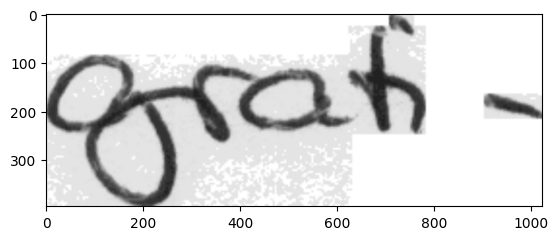

In [ ]:
import cv2
import typing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Import pandas to handle dataframes

from mltu.inferenceModel import OnnxInferenceModel
from mltu.utils.text_utils import ctc_decoder, get_cer
from tqdm import tqdm
from mltu.configs import BaseModelConfigs

class ImageToWordModel(OnnxInferenceModel):
    def __init__(self, char_list: typing.Union[str, list], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.char_list = char_list

    def predict(self, image: np.ndarray):
        image = cv2.resize(image, self.input_shapes[0][1:3][::-1])

        image_pred = np.expand_dims(image, axis=0).astype(np.float32)

        preds = self.model.run(self.output_names, {self.input_names[0]: image_pred})[0]

        text = ctc_decoder(preds, self.char_list)[0]

        return text

if __name__ == "__main__":
    configs = BaseModelConfigs.load("Models/03_handwriting_recognition/202301111911/configs.yaml")

    model = ImageToWordModel(model_path=configs.model_path, char_list=configs.vocab)

    df = pd.read_csv("Models/03_handwriting_recognition/202301111911/val.csv").values.tolist()

    accum_cer = []
    for image_path, label in tqdm(df):
        # Handle potential non-string labels
        if not isinstance(label, str):
            print(f"Skipping entry with non-string label: {label}")
            continue # Skip to the next iteration

        image = cv2.imread(image_path.replace("\\", "/"))
        prediction_text = model.predict(image)
        cer = get_cer(prediction_text, label)
        print(f"Image: {image_path}, Label: {label}, Prediction: {prediction_text}, CER: {cer}")
        accum_cer.append(cer)

        # resize by 4x
        image = cv2.resize(image, (image.shape[1] * 4, image.shape[0] * 4))
        plt.imshow(image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Calculate average CER only if accum_cer is not empty
    if accum_cer:
        print(f"Average CER: {np.average(accum_cer)}")
    else:
        print("No valid CER values calculated.")

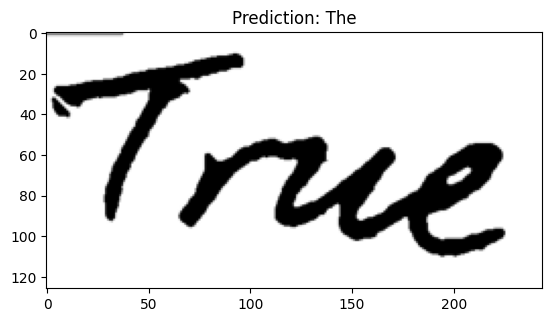

In [ ]:
def test_image(model, image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image from path: {image_path}")
        return

    prediction_text = model.predict(image)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {prediction_text}")
    plt.show()

if __name__ == "__main__":
    configs = BaseModelConfigs.load("Models/03_handwriting_recognition/202301111911/configs.yaml")
    model = ImageToWordModel(model_path=configs.model_path, char_list=configs.vocab)

    # Test a single image from your laptop
    test_image_path = "/content/true2.png"  # Update this with the path to your image
    test_image(model, test_image_path)